## 逻辑回归用于讽刺文本检测

---

本次挑战使用论文 [<i class="fa fa-external-link-square" aria-hidden="true"> A Large Self-Annotated Corpus for Sarcasm</i>](https://arxiv.org/abs/1704.05579) 提供的语料数据。该语料数据来源于 Reddit 论坛，挑战通过下面的链接下载并解压数据：

In [ ]:
!wget -nc "http://labfile.oss.aliyuncs.com/courses/1283/train-balanced-sarcasm.csv.zip"
!unzip -o "train-balanced-sarcasm.csv.zip"

首先，导入挑战所需的必要模块。

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

然后，加载语料并预览。

In [3]:
train_df = pd.read_csv('train-balanced-sarcasm.csv')
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


查看数据集变量类别信息。

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


`comment` 的数量小于其他特征数量，说明存在缺失值。这里直接将这些缺失数据样本删除。

In [5]:
train_df.dropna(subset=['comment'], inplace=True)

输出数据标签，看一看类别是否平衡。

In [6]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

最后，将数据切分为训练和测试集。

In [7]:
train_texts, valid_texts, y_train, y_valid = \
    train_test_split(train_df['comment'], train_df['label'], random_state=17)

### 数据可视化探索

首先，使用条形图可视化讽刺和正常文本长度，这里利用 `np.log1p` 对数据进行平滑处理，压缩到一定区间范围内。

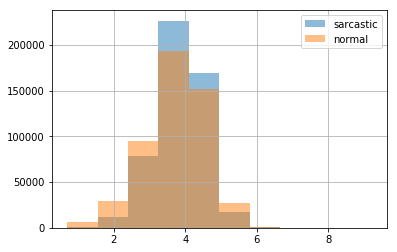

In [8]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(
    np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(
    np.log1p).hist(label='normal', alpha=.5)
plt.legend()

可以看的，二者在不同长度区间范围（横坐标）的计数分布比较均匀。接下来，挑战需要利用 WordCloud 绘制讽刺文本和正常文本关键词词云图。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>参考 [<i class="fa fa-external-link-square" aria-hidden="true"> WordCloud 官方文档</i>](https://github.com/amueller/word_cloud) 绘制两类评论文本词云图，可自定义样式效果。

In [9]:
!pip install wordcloud  # 安装必要模块

In [10]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black', stopwords=STOPWORDS,
                      max_words=200, max_font_size=100,
                      random_state=17, width=800, height=400)

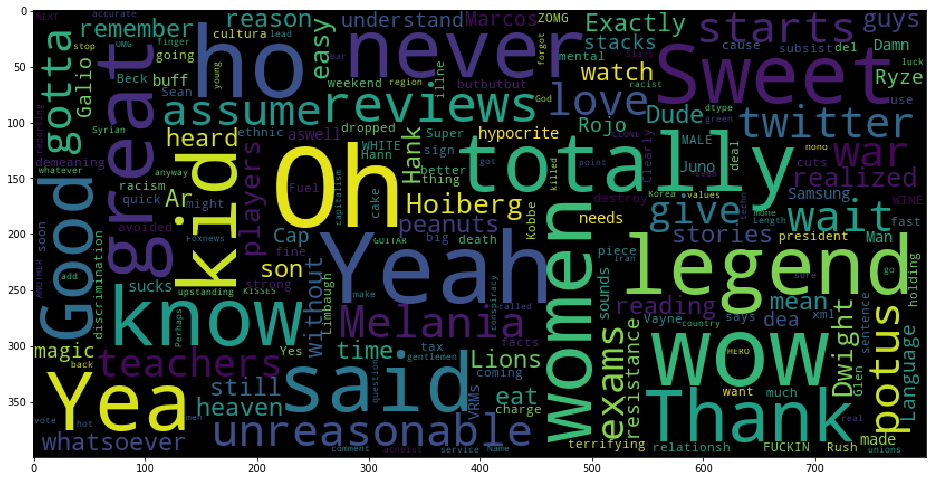

In [11]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud)

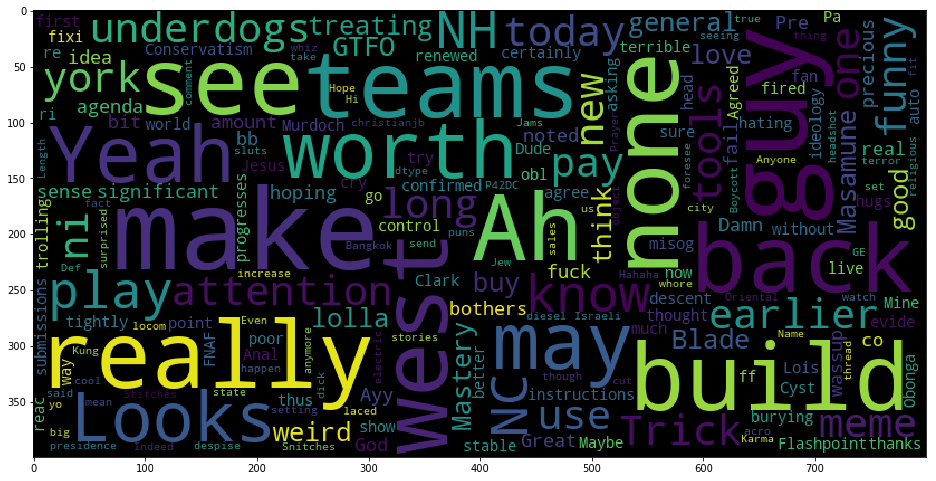

In [12]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud)

词云非常好看，但往往看不出太多有效信息。

`subreddit` 表示评论归属于 Reddit 论坛子板块信息。下面，我们使用 `groupby` 来确定各子板块讽刺评论数量排序。

In [13]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


上面的代码中，`np.size` 可以计算出不同子板块评论的总数。由于讽刺评论的标签为 1，正常评论为 0，所以通过 `sum` 求和操作就可以直接求出讽刺评论的计数。同理，`mean` 即代表讽刺评论所占比例。这是一个分析处理小技巧。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>沿用以上数据，输出子板块评论数大于 1000 且讽刺评论比例排名前 10 的信息。

In [14]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


同理，可以从用户的维度去分析讽刺评论的比例分布。下面就需要分析得出不同用户 `author` 发表评论的数量、讽刺评论的数量及比例。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>输出发表评论总数大于 300，且讽刺评论比例最高的 10 位用户信息。

In [15]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


### 训练分类模型

接下来，我们训练讽刺评论分类预测模型。这里，我们使用 tf-idf 提取文本特征，并建立逻辑回归模型。

In [16]:
# 使用 tf-idf 提取文本特征
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# 建立逻辑回归模型
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs',
                           random_state=17, verbose=1)
# 使用 sklearn pipeline 封装 2 个步骤
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf),
                                 ('logit', logit)])

下面就可以开始训练模型了。由于数据量较大，代码执行时间较长，请耐心等待。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>训练讽刺文本分类预测模型，并得到测试集上的准确度评估结果。

In [17]:
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.6s finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru... penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False))])

In [18]:
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

In [19]:
accuracy_score(y_valid, valid_pred)

0.7208560551497067

### 模型解释

接下来，挑战构建一个混淆矩阵的函数 `plot_confusion_matrix`。

In [20]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7, 7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

应用 `plot_confusion_matrix` 绘制出测试数据原始标签和预测标签类别的混淆矩阵。

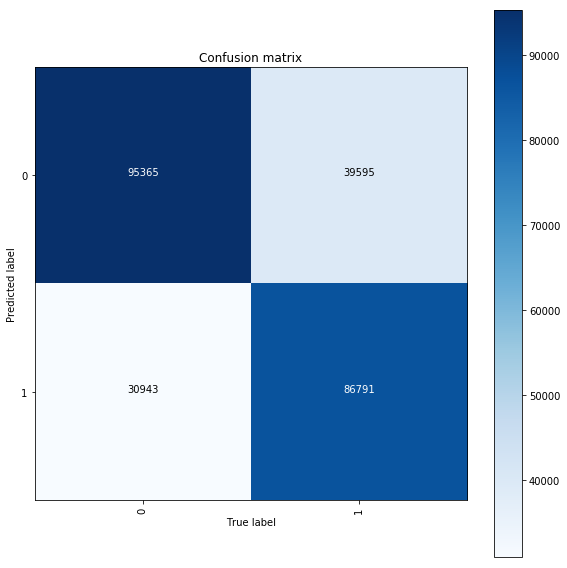

In [21]:
plot_confusion_matrix(y_valid, valid_pred,
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

实际上，这里利用 `eli5` 可以输出分类器在预测判定是文本特征的权重。

In [22]:
!pip install eli5  # 安装必要模块

In [23]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.328,yes because
+7.904,clearly
+7.374,obviously
+7.268,yeah because
+6.880,totally
+6.192,because
+6.080,how dare
+5.935,right because
+5.405,but thought
+5.234,duh


我们可以发现，讽刺评论通常都喜欢使用 yes, clearly 等带有肯定意味的词句。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557034785375">

### 模型改进

接下来，我们期望模型能得到进一步改进，所以再补充一个 `subreddit` 特征，同样完成切分。注意，这里切分时一定要选择同一个 `random_state`，保证能和上面的评论数据对齐。

In [24]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(
    subreddits, random_state=17)

接下来，同样使用 tf-idf 算法分别构建 2 个 `TfidfVectorizer` 用于 `comment` 和 `subreddits` 的特征提取。

In [25]:
tf_idf_texts = TfidfVectorizer(
    ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>使用构建好的 `TfidfVectorizer` 完成特征提取。

In [26]:
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

In [27]:
X_train_texts.shape, X_valid_texts.shape

((758079, 50000), (252694, 50000))

In [28]:
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

In [29]:
X_train_subreddits.shape, X_valid_subreddits.shape

((758079, 13255), (252694, 13255))

然后，将提取出来的特征拼接在一起。

In [30]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [31]:
X_train.shape, X_valid.shape

((758079, 63255), (252694, 63255))

最后，同样使用逻辑回归进行建模和预测。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>使用新特征训练逻辑回归分类模型并得到测试集上的分类准确度。

In [32]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.5s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False)

In [33]:
valid_pred = logit.predict(X_valid)

In [34]:
accuracy_score(y_valid, valid_pred)

0.7237647114692078

不出意外的话，准确度会更高一些。

<i class="fa fa-link" aria-hidden="true"> 相关链接</i> 

- [<i class="fa fa-external-link-square" aria-hidden="true"> Machine learning library Scikit-learn</i>](https://scikit-learn.org/stable/index.html)
- [<i class="fa fa-external-link-square" aria-hidden="true"> Kernels on logistic regression</i>](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification)
- [<i class="fa fa-external-link-square" aria-hidden="true"> ELI5 to explain model predictions</i>](https://github.com/TeamHG-Memex/eli5)

---

<div style="background-color: #e6e6e6; margin-bottom: 10px; padding: 1%; border: 1px solid #ccc; border-radius: 6px;text-align: center;"><a href="https://nbviewer.jupyter.org/github/shiyanlou/mlcourse-answers/tree/master/" title="挑战参考答案"><i class="fa fa-file-code-o" aria-hidden="true"> 查看挑战参考答案</i></a></div>